In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
cnn_model = mmsom.create_cnn_model()

In [4]:
alexnet = AlexNet(weights='../alexnet_weights.h5')

In [12]:
tokens = pd.read_table('/data/master_thesis/Flickr8k.lemma.token.txt',
                       names=['fname', 'doc'], index_col='fname', )
tokens['fname'] = tokens.index.str.replace(r'#\d', '')
tokens.head()

,doc,fname
fname,,
1305564994_00513f9a5b.jpg#0,A man in street racer armor be examine the tir...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#1,Two racer drive a white bike down a road .,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#2,Two motorist be ride along on their vehicle th...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#3,Two person be in a small race car drive by a g...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#4,Two person in race uniform in a street car .,1305564994_00513f9a5b.jpg


In [11]:
vec2word_fname = Path('vec2word.csv')
if vec2word_fname.exists():
    vec2word = pd.read_csv(vec2word_fname)
else:
    words = set()
    for doc in tokens.doc:
        words |= set(map(str.strip, map(str.lower, doc.split())))
    vec2word = [token for word in words for token in nlp(word)]
    vec2word = [list(token.vector) + [token.orth_] for token in vec2word
                if token.pos_ in ('NOUN', 'PROPN')]
    vec2word = pd.DataFrame(vec2word, columns=[f'vector_{i}' for i in range(300)] + ['word'])
    groups = vec2word.groupby('word')
    vec2word = pd.concat((groups.transform('mean'), vec2word.word), axis=1)
    vec2word = vec2word.drop_duplicates()
    vec2word.to_csv(vec2word_fname, index=False)
vec2word.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_291,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,word
0,0.385300,0.13618,0.59719,0.183430,-0.141900,-0.064433,0.091606,0.57574,0.88234,0.63385,...,-0.063343,-0.72641,0.592020,0.14770,-0.091060,-0.111260,-0.32848,0.565230,-0.67985,wicket
1,-0.016269,-0.66774,-0.21387,-0.479190,-0.624370,0.551470,-0.091257,-0.26658,0.36018,0.88362,...,0.087071,-0.31702,0.490470,-0.24666,0.655510,0.140950,0.53461,-0.324080,0.24846,monkey
2,-0.400600,-0.16396,0.40008,0.835210,-0.357100,0.827780,-0.138230,-0.16133,-0.23525,1.46380,...,-0.412130,-0.43138,0.003545,0.00082,-0.367900,-0.242250,-0.65519,-0.242870,0.55420,source
3,0.012832,0.22669,-0.17511,0.602480,0.096562,-0.206570,0.390550,-0.64990,0.12015,3.19590,...,0.086623,-0.16848,0.424830,0.34597,0.029642,0.002229,0.17134,0.040047,-0.37131,mother
4,0.693840,-1.34820,0.30036,0.009335,-0.206420,-0.016727,0.267700,-0.54181,-0.53659,0.58871,...,-0.250110,0.10779,0.265700,-0.17284,0.312720,0.003351,0.53952,0.252890,-0.35419,drap


In [10]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_word/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
groups = test_captions.groupby('fname')
test_captions = pd.concat((test_captions,
                           groups.rank().rename(columns={'doc': 'doc_rank'}).astype(int)),
                          axis=1)\
                  .sort_values(['fname', 'doc_rank'])
test_captions.head()

,fname,doc,doc_rank
2475,101669240_b2d3e7f17b.jpg,A man in a hat be display picture next to a sk...,1
2476,101669240_b2d3e7f17b.jpg,A man ski past another man display painting in...,2
2477,101669240_b2d3e7f17b.jpg,A person wear ski look at framed picture set u...,3
2478,101669240_b2d3e7f17b.jpg,A skier look at framed picture in the snow nex...,4
2479,101669240_b2d3e7f17b.jpg,Man on ski look at artwork for sale in the snow,5


In [13]:
train_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_word/train_captions.csv')
train_captions = pd.read_csv(train_captions_fname)
groups = train_captions.groupby('fname')
train_captions = pd.concat((train_captions,
                           groups.rank().rename(columns={'doc': 'doc_rank'}).astype(int)),
                          axis=1)\
                   .sort_values(['fname', 'doc_rank'])
train_captions.head()

,fname,doc,doc_rank
27860,1000268201_693b08cb0e.jpg,A child in a pink dress be climb up a set of s...,1
27861,1000268201_693b08cb0e.jpg,A girl go into a wooden building .,2
27862,1000268201_693b08cb0e.jpg,A little girl climb into a wooden playhouse .,3
27863,1000268201_693b08cb0e.jpg,A little girl climb the stair to her playhouse .,4
27864,1000268201_693b08cb0e.jpg,A little girl in a pink dress go into a wooden...,5


In [14]:
vec2img_fname = Path('vec2img.csv')
if vec2img_fname.exists():
    vec2img = pd.read_csv(vec2img_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img = []
    for fname in tqdmn(list(img_dir.glob('*.jpg'))):
        vec2img.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img = pd.DataFrame(
        vec2img, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img = vec2img.set_index('fname')
    vec2img.to_csv(vec2img_fname)
vec2img.head()

HBox(children=(IntProgress(value=0, max=8091), HTML(value='')))

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/937559727_ae2613cee5.jpg,0.0,0.000000,0.0,0.000000,0.000000,0.403997,0.393894,1.118511,0.0,0.101588,...,0.000000,0.0,0.707122,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/241374292_11e3198daa.jpg,0.0,0.000000,0.0,0.296848,0.000000,0.000000,0.242252,0.485356,0.0,0.000000,...,0.000000,0.0,0.000000,0.784748,0.000000,0.0,0.000000,0.0,0.186663,0.000000
/data/master_thesis/Flickr8k_Dataset/3046949818_245b05f507.jpg,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.322675,0.0,0.000000,1.958777
/data/master_thesis/Flickr8k_Dataset/2590207488_ddd89037ba.jpg,0.0,3.717375,0.0,0.000000,0.971882,0.581444,2.899128,0.000000,0.0,0.000000,...,0.585798,0.0,0.000000,0.000000,0.317887,0.0,0.000000,0.0,0.000000,2.286348
/data/master_thesis/Flickr8k_Dataset/1931690777_897a7d8ab6.jpg,0.0,0.000000,0.0,0.924576,0.580005,0.000000,2.660404,0.000000,0.0,0.000000,...,2.824198,0.0,0.000000,0.000000,0.000000,0.0,0.176782,0.0,0.187770,0.217622


In [17]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

In [15]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/1024138940_f1fefbdce1.jpg,0.000000,3.137011,0.0,0.0,3.818629,0.000000,0.0,0.000000,0.0,0.000000,...,0.00000,0.0,0.96088,0.000000,0.000000,2.195693,0.0,0.0,0.0,0.919153
/data/master_thesis/Flickr8k_Dataset/3084001782_41a848df4e.jpg,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.059794,0.0,0.000000,...,0.72579,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
/data/master_thesis/Flickr8k_Dataset/359173181_a75c950aeb.jpg,1.059678,2.333830,0.0,0.0,0.969706,0.000000,0.0,0.000000,0.0,0.000000,...,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.045058
/data/master_thesis/Flickr8k_Dataset/2752043092_f48ebfeaa2.jpg,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.256935,0.0,1.921452,...,0.00000,0.0,0.00000,0.000000,0.739085,0.000000,0.0,0.0,0.0,0.000000
/data/master_thesis/Flickr8k_Dataset/2356664078_4b1e6e465d.jpg,0.000000,0.000000,0.0,0.0,0.000000,0.988852,0.0,0.000000,0.0,0.000000,...,0.00000,0.0,0.00000,1.599689,0.000000,0.000000,0.0,0.0,0.0,0.099152


In [18]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(model.som_model.codebook.reshape(10000, 4396))

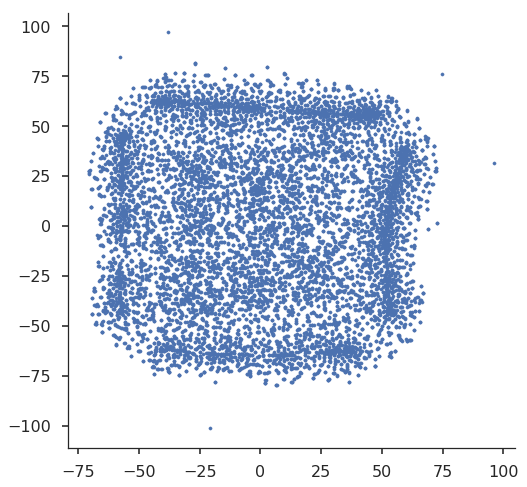

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(*projection.T, s=10)
sns.despine()

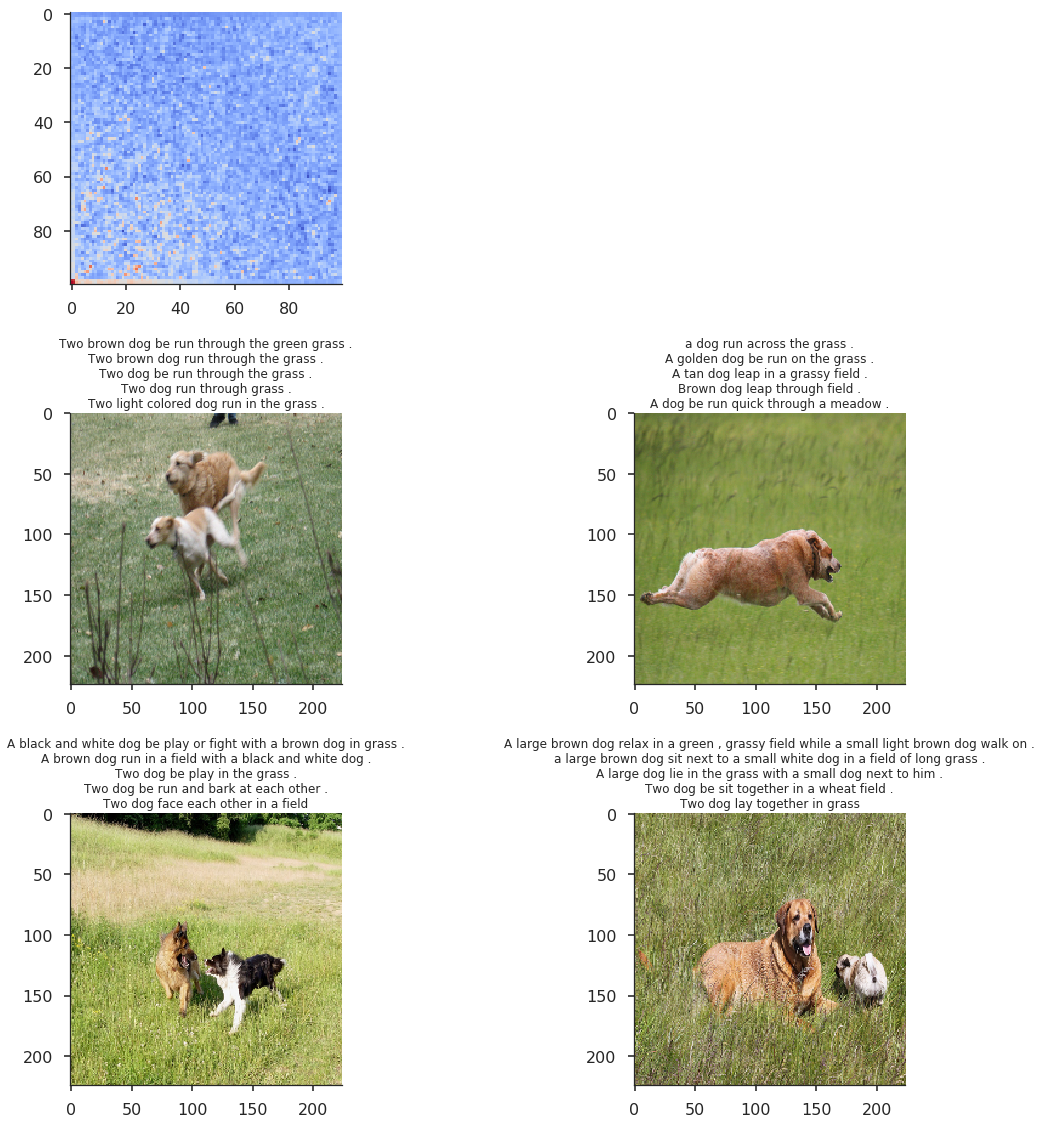

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()
knn_ids = model.get_knn_images(doc='dog water', k=4, vec2img=vec2img_test, ax=axes[0])
knn = vec2img_test.index[knn_ids]
for ax, fname in zip(axes[2:], knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    ax.imshow(img)
    ax.set_title('\n'.join(tokens.loc[tokens.fname.str.contains(fname.name), 'doc']),
                 fontsize=12)
fig.delaxes(axes[1])
sns.despine()
plt.tight_layout()

In [21]:
test_words_fname = Path('test_words.csv')
if test_words_fname.exists():
    test_words = pd.read_csv(test_words_fname)
else:
    test_words = []
    for _, row in tqdmn(test_captions.iterrows(), total=len(test_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.doc.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            test_words.append((row.fname, row.doc_rank, word))
    test_words = pd.DataFrame(test_words, columns=('fname', 'doc_rank', 'word'))
    test_words = test_words.drop_duplicates().reset_index(drop=True)
    test_words.to_csv(test_words_fname, index=False)
test_words.head()

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

,fname,doc_rank,word
0,101669240_b2d3e7f17b.jpg,1,hat
1,101669240_b2d3e7f17b.jpg,1,display
2,101669240_b2d3e7f17b.jpg,1,picture
3,101669240_b2d3e7f17b.jpg,1,skier
4,101669240_b2d3e7f17b.jpg,2,snow


In [24]:
train_words_fname = Path('train_words.csv')
if train_words_fname.exists():
    train_words = pd.read_csv(train_words_fname)
else:
    train_words = []
    for _, row in tqdmn(train_captions.iterrows(), total=len(train_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.doc.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            train_words.append((row.fname, row.doc_rank, word))
    train_words = pd.DataFrame(train_words, columns=('fname', 'doc_rank', 'word'))
    train_words = train_words.drop_duplicates().reset_index(drop=True)
    train_words.to_csv(train_words_fname, index=False)
train_words.head()

HBox(children=(IntProgress(value=0, max=35460), HTML(value='')))

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/mtambos/anaconda/envs/thesis/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/mtambos/anaconda/envs/thesis/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



,fname,doc_rank,word
0,1000268201_693b08cb0e.jpg,1,way
1,1000268201_693b08cb0e.jpg,1,child
2,1000268201_693b08cb0e.jpg,1,entry
3,1000268201_693b08cb0e.jpg,1,stair
4,1000268201_693b08cb0e.jpg,2,girl


In [27]:
results_words = {}
for _, row in tqdmn(test_words.iterrows(), total=len(test_words)):
    fname, doc_rank, word = row
    knn_ids = model.get_knn_images(doc=word, k=10, vec2img=vec2img_test)
    knn = vec2img_test.index[knn_ids]
    results_words[(fname, doc_rank, word)] = knn.copy()
results_words

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

multimodal_som:143: RuntimeWarning: invalid value encountered in true_divide


{('101669240_b2d3e7f17b.jpg',
  1,
  'hat'): Index([ /data/master_thesis/Flickr8k_Dataset/370442541_60d93ecd13.jpg,
        /data/master_thesis/Flickr8k_Dataset/2844963839_ff09cdb81f.jpg,
        /data/master_thesis/Flickr8k_Dataset/3368865171_597d51cdd5.jpg,
        /data/master_thesis/Flickr8k_Dataset/2500354186_0836309cc9.jpg,
         /data/master_thesis/Flickr8k_Dataset/241345446_2e47ae8ddc.jpg,
        /data/master_thesis/Flickr8k_Dataset/3561639055_5ac66ae92f.jpg,
        /data/master_thesis/Flickr8k_Dataset/2039457436_fc30f5e1ce.jpg,
         /data/master_thesis/Flickr8k_Dataset/405961988_fcfe97f31e.jpg,
        /data/master_thesis/Flickr8k_Dataset/3039214579_43ef79f931.jpg,
         /data/master_thesis/Flickr8k_Dataset/241345942_ea76966542.jpg],
       dtype='object', name='fname'),
 ('101669240_b2d3e7f17b.jpg',
  1,
  'display'): Index([/data/master_thesis/Flickr8k_Dataset/3084011664_76d37c6559.jpg,
        /data/master_thesis/Flickr8k_Dataset/3728695560_00ec1ca492.jpg,
     

In [28]:
import pickle

with open('results_words.pickle', 'wb') as fp:
    pickle.dump(results_words, fp)

In [29]:
np.mean([1 if fname in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.0039546533087266014

In [1]:
np.mean([1 if fname in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

NameError: name 'np' is not defined

In [31]:
np.mean([1 if fname in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.031637226469812811

In [31]:
np.mean([1 if fname in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.031637226469812811